In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

import torchvision
from torchvision import datasets,transforms,models
import torchvision.transforms as transforms

In [2]:
df = pd.read_csv('../../charts/train_val.csv')

In [3]:
from PIL import Image, ImageOps
import csv, random
from torch.utils.data import DataLoader, Dataset

def image_transforms():
    return transforms.Compose([transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class SymbolDataset(Dataset):
    
    def __init__(self, base_path = '../../charts', transforms = None):
        
        super().__init__()
        self.base_path = base_path
        self.transforms = transforms
        self.labels = {'vbar_categorical': 0, 'hbar_categorical': 1, 'line': 2, 'pie': 3, 'dot_line': 4}

        self.X = []
        self.y = []

        folder_name = 'train_val'
        csv_path = os.path.join(base_path, "train_val.csv")

        with open(csv_path) as f:
            reader = csv.reader(f)
            next(f)
            for row in reader:
                f_name = os.path.join(base_path, folder_name, row[0]+'.png')
                img = Image.open(f_name).convert('RGB')

                self.X.append(img)
                self.y.append(row[1])
        
    def __getitem__(self, index):

        image = self.X[index]
        label = self.y[index]

        if self.transforms:
            image = self.transforms(image)
        
        return image, torch.tensor(self.labels[label])
        
    def __len__(self):
        return len(self.X)

dataset = SymbolDataset(transforms=image_transforms())

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
                
def create_model():
    model_ft = models.alexnet(pretrained=True)
    num_classes = 5

    set_parameter_requires_grad(model_ft, True)

    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    model_ft = model_ft.to(device)

    params_to_update = model_ft.parameters()
    print("Params to learn:")

    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            
    optimizer_ft = optim.Adam(params_to_update, lr=0.001, weight_decay = 0.0001)
    
    return model_ft, optimizer_ft

In [5]:
from sklearn.model_selection import KFold

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

num_epochs = 15
batch_size = 32

k = 10
splits = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf = {}

In [6]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model_ft, optimizer_ft = create_model()
    
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss,train_correct=0.0,0
        model_ft.train()
        for images, labels in train_loader:

            images,labels = images.to(device),labels.to(device)
            optimizer_ft.zero_grad()
            output = model_ft(images)

            loss = criterion(output,labels)
            loss.backward()
            optimizer_ft.step()
            train_loss += loss.item() * images.size(0)
            scores, predictions = torch.max(output.data, 1)
            train_correct += (predictions == labels).sum().item()

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
            
        test_loss, test_correct = 0.0, 0
        model_ft.eval()
        for images, labels in test_loader:

            images,labels = images.to(device),labels.to(device)
            output = model_ft(images)

            loss = criterion(output,labels)
            test_loss += loss.item()*images.size(0)
            scores, predictions = torch.max(output.data,1)
            test_correct += (predictions == labels).sum().item()

        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history  

Fold 1
Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch:1/15 AVG Training Loss:0.285 AVG Test Loss:0.124 AVG Training Acc 91.44 % AVG Test Acc 97.00 %
Epoch:2/15 AVG Training Loss:0.081 AVG Test Loss:0.051 AVG Training Acc 97.33 % AVG Test Acc 98.00 %
Epoch:3/15 AVG Training Loss:0.062 AVG Test Loss:0.119 AVG Training Acc 97.78 % AVG Test Acc 98.00 %
Epoch:4/15 AVG Training Loss:0.064 AVG Test Loss:0.048 AVG Training Acc 97.78 % AVG Test Acc 99.00 %
Epoch:5/15 AVG Training Loss:0.041 AVG Test Loss:0.065 AVG Training Acc 98.56 % AVG Test Acc 96.00 %
Epoch:6/15 AVG Training Loss:0.068 AVG Test Loss:0.081 AVG Training Acc 97.78 % AVG Test Acc 97.00 %
Epoch:7/15 AVG Training Loss:0.042 AVG Test Loss:0.067 AVG Training Acc 98.78 % AVG Test Acc 97.00 %
Epoch:8/15 AVG Training Loss:0.046 AVG Test Loss:0.088 AVG Training Acc 98.67 % AVG Test Acc 96.00 %
Epoch:9/15 AVG Training Loss:0.043 AVG Test Loss:0.113 AVG Training Acc 98.33 % AVG Test Acc 96.00 %
Epoch:10/15 AVG Training 

Epoch:3/15 AVG Training Loss:0.073 AVG Test Loss:0.056 AVG Training Acc 97.89 % AVG Test Acc 98.00 %
Epoch:4/15 AVG Training Loss:0.064 AVG Test Loss:0.049 AVG Training Acc 97.44 % AVG Test Acc 98.00 %
Epoch:5/15 AVG Training Loss:0.054 AVG Test Loss:0.028 AVG Training Acc 98.44 % AVG Test Acc 100.00 %
Epoch:6/15 AVG Training Loss:0.062 AVG Test Loss:0.025 AVG Training Acc 97.78 % AVG Test Acc 100.00 %
Epoch:7/15 AVG Training Loss:0.055 AVG Test Loss:0.059 AVG Training Acc 97.89 % AVG Test Acc 98.00 %
Epoch:8/15 AVG Training Loss:0.082 AVG Test Loss:0.008 AVG Training Acc 97.33 % AVG Test Acc 100.00 %
Epoch:9/15 AVG Training Loss:0.036 AVG Test Loss:0.013 AVG Training Acc 99.00 % AVG Test Acc 100.00 %
Epoch:10/15 AVG Training Loss:0.038 AVG Test Loss:0.034 AVG Training Acc 98.89 % AVG Test Acc 99.00 %
Epoch:11/15 AVG Training Loss:0.045 AVG Test Loss:0.051 AVG Training Acc 98.44 % AVG Test Acc 98.00 %
Epoch:12/15 AVG Training Loss:0.056 AVG Test Loss:0.043 AVG Training Acc 97.67 % AVG 

In [7]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10

for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \nAverage Test Loss: {:.3f} \nAverage Training Acc: {:.2f} \nAverage Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))  

Performance of 10 fold cross validation
Average Training Loss: 0.071 
Average Test Loss: 0.049 
Average Training Acc: 97.65 
Average Test Acc: 98.42


<Figure size 432x288 with 0 Axes>

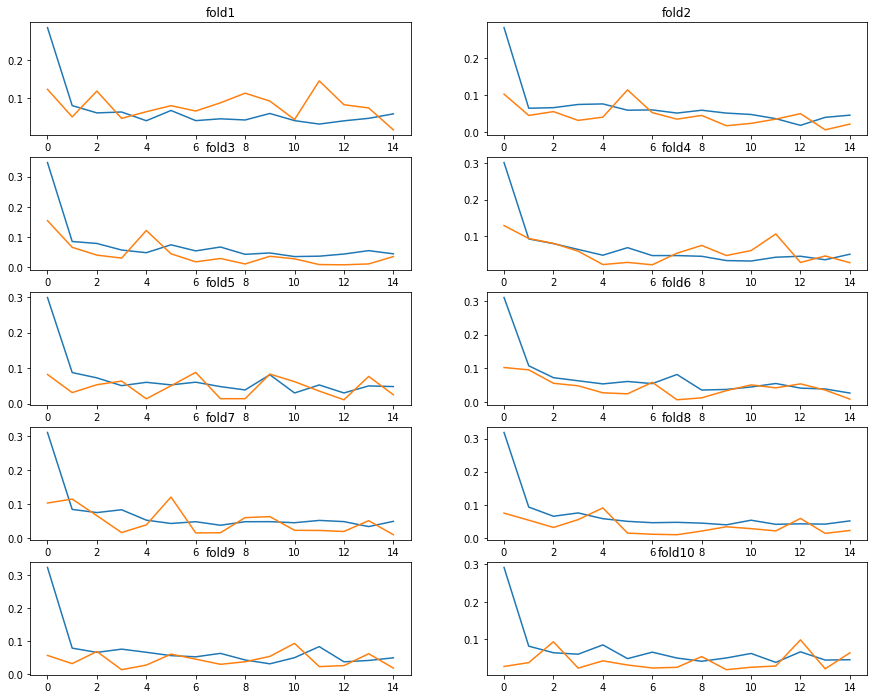

In [8]:
count=1

plt.subplots_adjust(hspace=1)
plt.subplots(figsize=(15, 12))

for i in range(10):
    plt.subplot(5, 2,count)
    plt.title(f'fold{i+1}')
    plt.plot(foldperf[f'fold{i+1}']['train_loss'])
    plt.plot(foldperf[f'fold{i+1}']['test_loss'])
    count+=1

plt.show()

<Figure size 432x288 with 0 Axes>

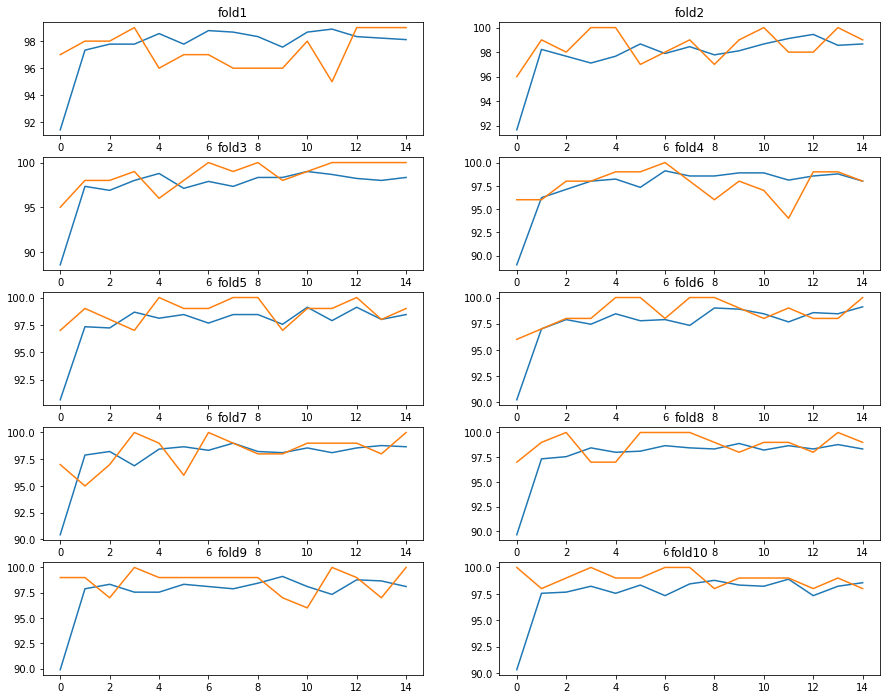

In [10]:
count=1

plt.subplots_adjust(hspace=1)
plt.subplots(figsize=(15, 12))

for i in range(10):
    plt.subplot(5, 2,count)
    plt.title(f'fold{i+1}')
    plt.plot(foldperf[f'fold{i+1}']['train_acc'])
    plt.plot(foldperf[f'fold{i+1}']['test_acc'])
    count+=1

plt.show()

In [12]:
torch.save(model_ft.state_dict(), 'ckpt.pth')

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


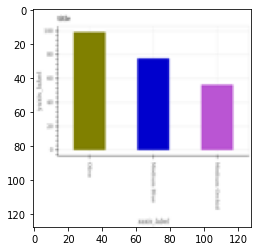

hbar_categorical


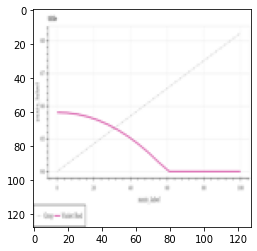

line


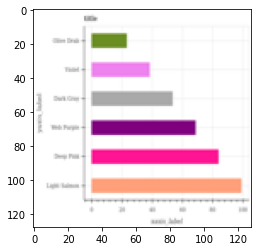

hbar_categorical


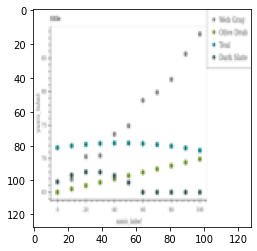

dot_line


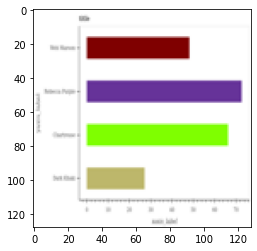

hbar_categorical


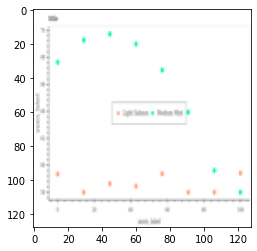

dot_line


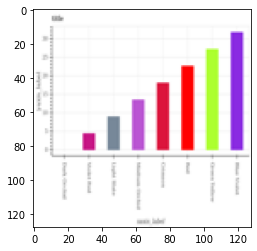

vbar_categorical


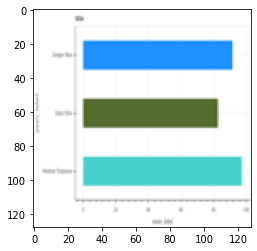

hbar_categorical


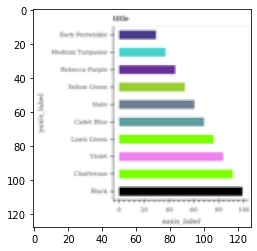

hbar_categorical


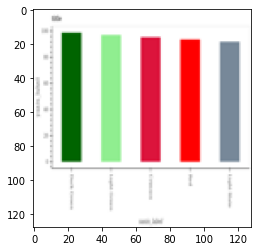

vbar_categorical


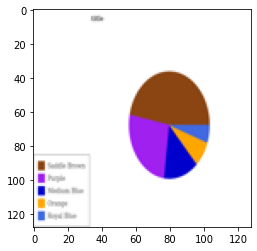

pie


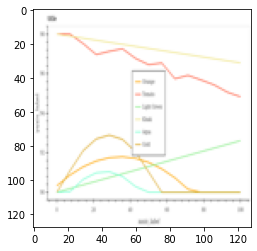

line


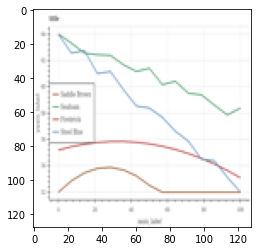

line


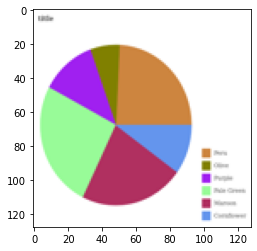

pie


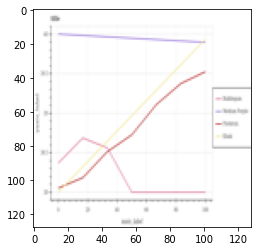

line


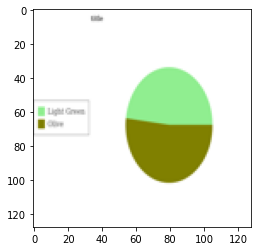

pie


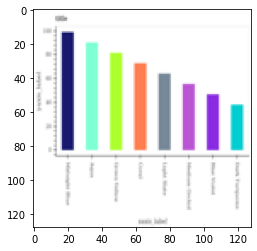

vbar_categorical


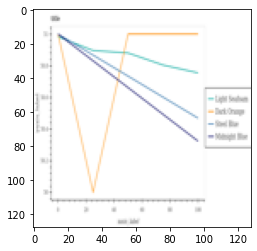

line


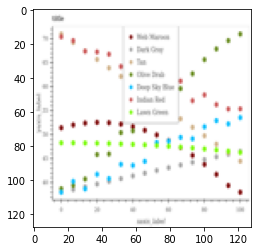

dot_line


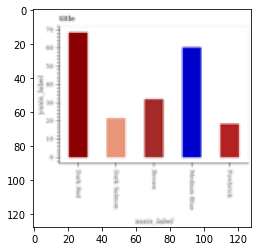

vbar_categorical


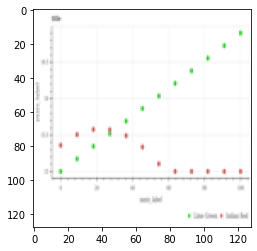

dot_line


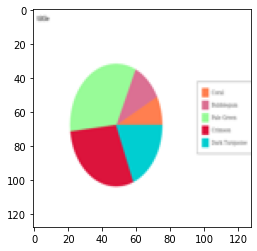

pie


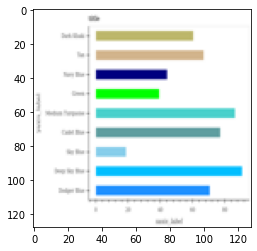

hbar_categorical


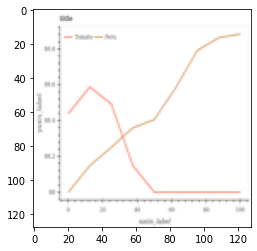

line


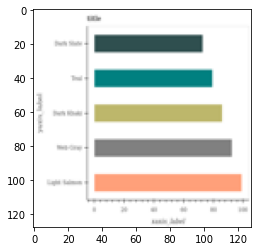

hbar_categorical


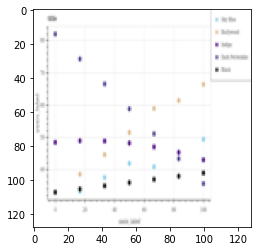

dot_line


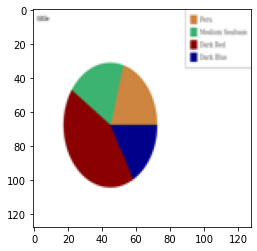

pie


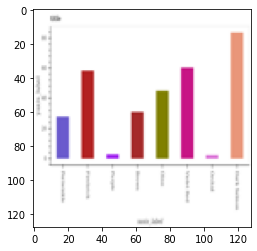

vbar_categorical


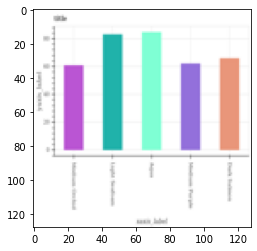

vbar_categorical


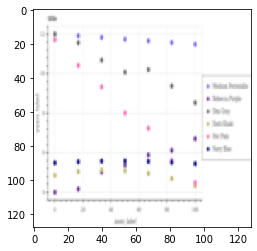

dot_line


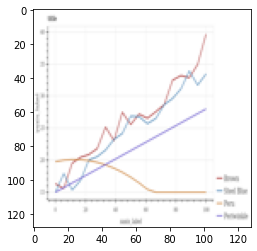

line


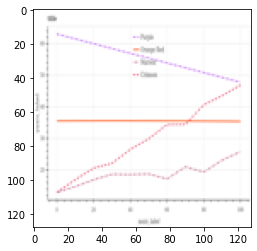

line


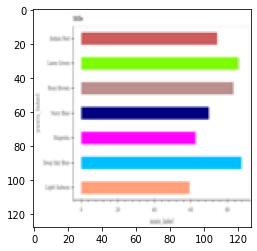

hbar_categorical


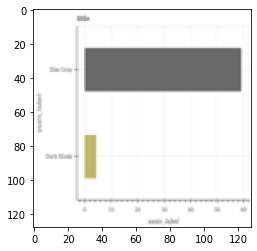

hbar_categorical


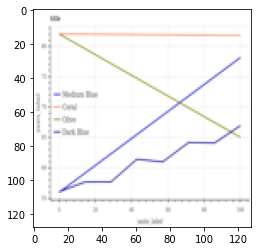

line


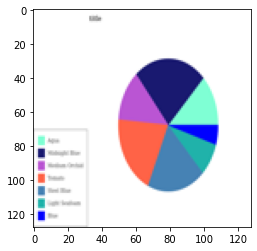

pie


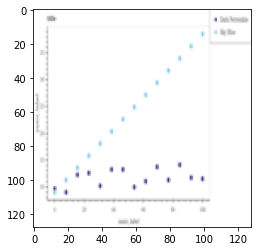

dot_line


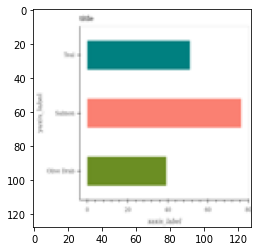

hbar_categorical


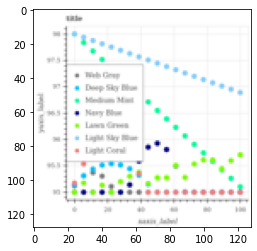

dot_line


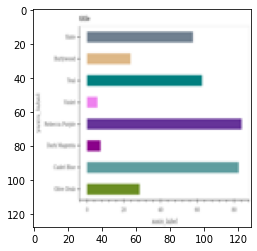

hbar_categorical


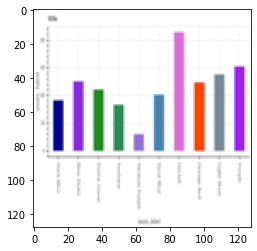

vbar_categorical


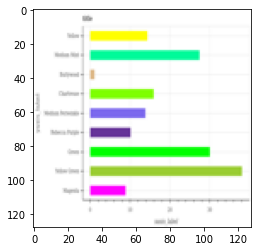

hbar_categorical


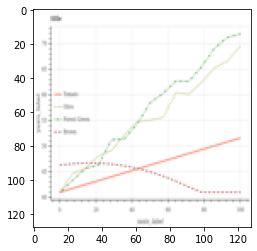

line


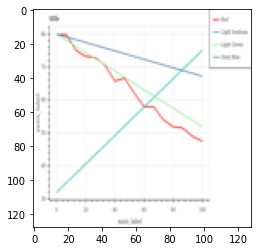

line


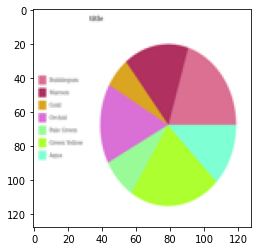

pie


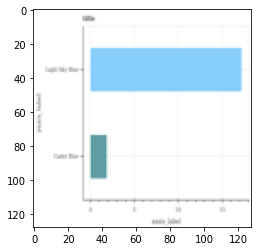

hbar_categorical


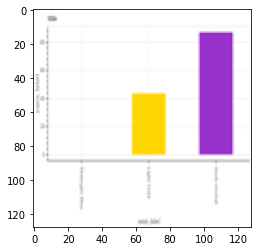

vbar_categorical


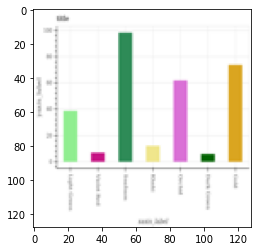

vbar_categorical


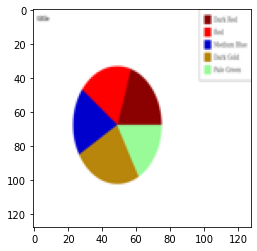

pie


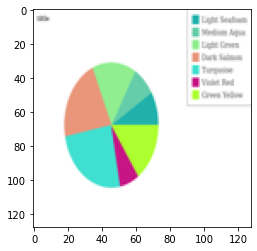

pie


In [22]:
import random

net, _ = create_model()
net.load_state_dict(torch.load('ckpt.pth'))
net.eval()
# test_image = Image.open(os.path.join('data/test', random.choice(os.listdir('data/test'))))
for f in os.listdir('../../dataset/test'):
    test_image = Image.open(os.path.join('../../dataset/test', f)).convert('RGB')
    plt.imshow(np.asarray(test_image))
    plt.show()

    label = ['vbar_categorical', 'hbar_categorical', 'line', 'pie', 'dot_line']
    data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    input_tensor = data_transforms(test_image).to(device)

    net.eval()
    output = net(input_tensor.unsqueeze(0))

    print(label[torch.argmax(output)])